# LCPB 21-22 exercise 4: XGBoost

Alessandro Zanoli, Emerson Rodrigues Vero filho, Luca Giorgetti, Raffaele Gaudio

#### TASK 1

Consider the dataset generated for exercise 03 on convolutional neural networks (CNN), namely the samples of the stochastic time series with labels 0,1,2 depending on the eventual addition of another transient signal.

a) Compare the accuracy of a CNN with that of an XGBoost model trained with the features extracted by tsfresh from same data, in the limit of small datasets. For instance, try values of N=20, 50, 100, 150, 200, 250, 300, 400, 500. In all cases show also the standard deviation of the accuracy, obtained from several independent training and test procedures on different datasets.

b) For task a) we have seen during the lesson that XGBoost finds some features more relevant than others. Find the description of those features in the documentation and try to provide an explanation of why they are relevant for that problem.

c) OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed forward neural network (FFNN) and compare the performances with those of XGBoost. Than keep only the most relevant features from XGBoost and train another FFNN with this smaller set. Is the new FFNN working better than the one trained with all features?

#### TASK 2

For the labeling of simple two dimensional data (as the one generated during the lesson), try different parameters (gamma, lambda, n_estimators, ...), aiming to find the simplest yet effective XGBoost model that keeps a good accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.random as tf_r
from scipy.signal import detrend # for CNN

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import clone_model

from xgboost import XGBRegressor
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
from keras import regularizers, initializers
from sklearn.metrics import accuracy_score

plt.style.use('seaborn')
plt.rcParams['font.size'] = 14

np.random.seed(12345)
tf_r.set_seed(12345) 
%run plot.py

## Generate Data (1d time series)

In [2]:
# function for the random step, using lambda construction
# int() for cleaner look and for mimiking a detector with finite resolution
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))

def pattern(i,z,a):
    return int(a*np.sin((np.pi*i)/z))

[0, -5, 23, 3, -19, 84, 158, 167, 186, 229, 296, 351, 292, 310, 326, 398, 447, 352, 339, 427, 411, 390, 418, 585, 539, 516, 527, 547, 578, 583, 655, 625, 589, 476, 388, 350, 383, 325, 335, 287, 308, 196, 192, 120, 77, 17, 36, 59, 27, 48, 120, 128, 145, 149, 204, 275, 235, 163, 169, 211] 0
[183, 231, 235, 242, 280, 327, 285, 288, 307, 400, 449, 468, 575, 634, 655, 661, 561, 431, 270, 110, 126, 133, 81, 126, 152, 207, 303, 259, 306, 305, 355, 369, 482, 482, 587, 593, 637, 647, 615, 649, 661, 588, 565, 568, 527, 508, 511, 570, 624, 600, 684, 663, 690, 741, 668, 622, 607, 623, 619, 657] 1
[580, 623, 678, 663, 597, 579, 558, 521, 610, 643, 496, 417, 360, 369, 247, 190, 258, 256, 359, 489, 648, 783, 751, 706, 825, 746, 794, 774, 749, 796, 798, 793, 831, 835, 777, 810, 841, 801, 790, 777, 894, 865, 828, 836, 837, 826, 839, 855, 854, 851, 785, 799, 883, 811, 830, 807, 807, 804, 789, 732] 2


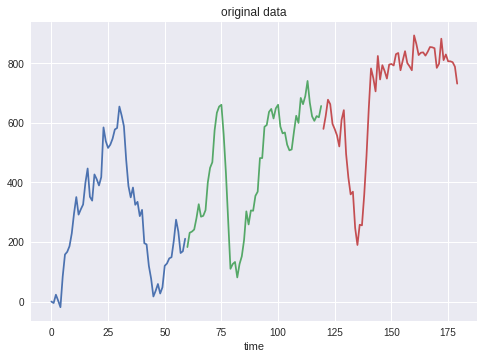

In [3]:
# pattern parameters: Z=nr of steps, A=amplitude
Z=12
A=500

# number of data samples
N=10000
# size of each sample of the timeseries
L=60
# step parameters: introduce small positive bias 
DX = 50
bias = 5

y = [0] * N # list of N zeros
x = [[0] * L for i in range(N)] # NxL matrix
                                #
for i in range(N):
    if i>0:
        x[i][0] = x[i-1][-1] + jump(bias,DX) #
    
    for j in range(1,L):
        x[i][j] = x[i][j-1] + jump(bias,DX)
        
    y[i] = i%3 
    ##y[i] = random.randint(0,2)
    if y[i]>0:
        j0 = np.random.randint(0,L-1-Z)
        ###print(i,j0,j1)
        sign = 3-2*y[i]
        for j in range(Z):
            x[i][j0+j] += sign*pattern(j,Z,A)
            
for i in range(min(3,N)):
    print(x[i],y[i])
    

Show_data(x,L,"original data")

In [4]:
#!mkdir DATA
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
print(str0)

fname='DATA/x_'+str0
np.savetxt(fname,x,fmt="%d")
fname='DATA/y_'+str0
np.savetxt(fname,y,fmt="%d")

ts_L60_Z12_A500_DX50_bias5_N10000.dat


## Loading Data

In [5]:
#use the dataset generated in the last exercise (we have to use the same data as in exercise 3 because we will compare the performances of CNN and Xgboost)

str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

data:  10000


## TSFRESH: extract features

In [6]:
#per i blocchi a seguire dobbiamo aggiustare l'input (abbiamo una serie 2d)

def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t) 
    #build time columns
    time_col = np.tile(np.arange(t),N) #genera n colonne di tempi 
    #build var column
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [7]:
df=get_df(x)
df

,id,time,value
0,0,0,0.0
1,0,1,-5.0
2,0,2,23.0
3,0,3,3.0
4,0,4,-19.0
...,...,...,...
599995,9999,55,2977193.0
599996,9999,56,2977276.0
599997,9999,57,2977286.0
599998,9999,58,2977386.0


In [8]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction: 100%|██████████| 20/20 [05:17<00:00, 15.87s/it]


In [9]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [10]:
#look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,16750.0,6.729150e+06,43.101695,3.576271,0.405172,289.5,...,0.239217,0.283936,0.424254,0.424254,0.980757,1.606551,2.560840,3.232518,3.608440,3.809279
1,1.0,0.0,0.0,1.0,27302.0,1.455619e+07,44.000000,8.033898,-0.086207,509.5,...,0.317937,0.379535,0.379535,0.518700,1.107653,1.547018,2.436717,3.108691,3.462655,3.659720
2,1.0,0.0,0.0,1.0,41650.0,3.090479e+07,45.491525,2.576271,-0.862069,784.0,...,0.142506,0.142506,0.379535,0.424254,1.107653,1.745508,2.930054,3.743700,4.007333,3.988984
3,1.0,0.0,0.0,1.0,37428.0,2.393510e+07,44.372881,-2.169492,1.008621,631.0,...,0.317937,0.473981,0.687083,1.320351,2.757282,1.695334,2.879917,3.584589,3.871793,3.937640
4,1.0,0.0,0.0,1.0,58260.0,6.072359e+07,54.593220,10.728814,-0.422414,909.0,...,0.239217,0.379535,0.424254,0.656671,0.838120,1.668815,2.785780,3.277698,3.575507,3.773917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.0,0.0,1.0,178577898.0,5.315011e+14,44.898305,3.813559,-0.232759,2976394.0,...,0.239217,0.283936,0.424254,0.563420,1.134027,1.588719,2.476201,3.245121,3.619739,3.789900
9996,1.0,0.0,0.0,1.0,178600157.0,5.316336e+14,40.288136,10.694915,-0.758621,2976629.0,...,0.142506,0.142506,0.283936,0.424254,1.237411,1.655861,2.603521,3.355240,3.786663,3.876606
9997,1.0,0.0,0.0,1.0,178618515.0,5.317429e+14,48.915254,-1.423729,-0.422414,2976910.5,...,0.239217,0.379535,0.424254,0.656671,0.928839,1.657902,2.624445,3.267602,3.634172,3.876606
9998,1.0,0.0,0.0,1.0,178611894.0,5.317035e+14,57.677966,-0.762712,0.577586,2976930.0,...,0.384543,0.457102,0.656671,0.838120,0.973558,1.643572,2.582843,3.294830,3.639092,3.757935


### Split train/validation

In [11]:
# label preparation for CNN
y_CNN = np.zeros((len(y),3))
for i,iy in enumerate(y):
    y_CNN[i][iy]=1

#shuffling data
perm=np.random.permutation(x_features.shape[0])

x_features=x_features.iloc[perm]
y = y[perm]
x = x[perm]
y_CNN = y_CNN[perm]

In [12]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)

if True:
    #rescaling x_features for XGB
    x_features -= np.mean(x_features,axis=0)
    x_features /= np.std(x_features,axis=0)

    # detrending and rescaling x for CNN
    for i in range(len(x)):
        x[i] = detrend(x[i])
    x /= np.var(x)

x = x.reshape((*x.shape,1)) # reshape for CNN

x_XGB_train = x_features[:N_train]
x_CNN_train = x[:N_train]
x_XGB_val = x_features[N_train:]
x_CNN_val = x[N_train:]

    
y_CNN_train = y_CNN[:N_train]
y_CNN_val = y_CNN[N_train:]
y_XGB_train = y[:N_train]
y_XGB_val = y[N_train:]

N_val = N-N_train
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)    

N_train= 8000   N_val= 2000   n_class= 3


# Build models

## XGBoost


In [13]:
#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model_XGB = XGBClassifier(**params)

## CNN Model

In [14]:
reg = regularizers.l2(0.1) 
ini = initializers.RandomNormal(mean=1.0,stddev=0.05,seed=12345)
M = 15 # lenght of kernel: its shape will be M
       # larger than Z=12 which is the size of the pattern

In [15]:
# define the model with no input shape

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=3,kernel_size=M,kernel_initializer=ini,kernel_regularizer=reg,input_shape=(L,1),use_bias=False))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=2,kernel_size=int(M/2)))
model_CNN.add(Flatten())
model_CNN.add(Dense(12,activation='sigmoid')) # just a 12 neurons layer
model_CNN.add(Dense(n_class,activation='softmax'))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=1000,decay_rate=0.9)
opt = tf.keras.optimizers.Adam()

# compile the model
model_CNN.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])


In [16]:
print('----- MODEL SUMMARY ------')
print(model_CNN.summary())

----- MODEL SUMMARY ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 3)             45        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 3)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 2)             44        
                                                                 
 flatten (Flatten)           (None, 34)                0         
                                                                 
 dense (Dense)               (None, 12)                420       
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                             

## XGBoos VS CNN on small datasets

In [28]:
# ENTER THE MEGACELLA OF DEATH

Ns_sub = [20,50,100,150,200,250,300,400,500]
bag_size = 16 # = 8000/500
verbose = True

# dictionary to store accuracy for xgb and cnn model, both for training set and validation set
accuracies = {"xgb" : {"train": np.zeros((len(Ns_sub),16)),
                        "val": np.zeros((len(Ns_sub),16))},
            "cnn" : {"train" : np.zeros((len(Ns_sub),16)),
                    "val" : np.zeros((len(Ns_sub),16))
            }
}

for i_n,N_sub in enumerate(Ns_sub):
    
    if verbose: print("Training {} subsets of size {}\n---------------------\n".format(bag_size,N_sub))

    for i in range(bag_size):
        
        if verbose: 
            print("Training subset number {} ...".format(i))
            print("Training XGBoost...")

        # XGBoost
        model_XGB.fit(x_XGB_train.iloc[N_sub*i:N_sub*(i+1)].values,y_XGB_train[N_sub*i:N_sub*(i+1)])
        
        y_xgb_pred_train = model_XGB.predict(x_XGB_train.iloc[N_sub*i:N_sub*(i+1)].values)
        y_xgb_pred_val = model_XGB.predict(x_XGB_val.values)

        accuracies["xgb"]["train"][i_n][i] = accuracy_score(y_XGB_train[N_sub*i:N_sub*(i+1)],y_xgb_pred_train)
        accuracies["xgb"]["val"][i_n][i] = accuracy_score(y_XGB_val,y_xgb_pred_val)

        if verbose: print("Training CNN...")
        # CNN

        model_temp_CNN = keras.models.clone_model(model_CNN) # clone anew
        model_temp_CNN.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
        model_temp_CNN.fit(x_CNN_train[N_sub*i:N_sub*(i+1)],y_CNN_train[N_sub*i:N_sub*(i+1)])

        y_cnn_pred_train = np.argmax(model_temp_CNN.predict(x_CNN_train[N_sub*i:N_sub*(i+1)]),axis=-1)
        y_cnn_pred_val = np.argmax(model_temp_CNN.predict(x_CNN_val),axis=-1)


        accuracies["cnn"]["train"][i_n][i] = accuracy_score(np.argmax(y_CNN_train[N_sub*i:N_sub*(i+1)],axis=-1),y_cnn_pred_train)
        accuracies["cnn"]["val"][i_n][i] = accuracy_score(np.argmax(y_CNN_val,axis=-1),y_cnn_pred_val)

Training 16 subsets of size 20
---------------------

Training subset number 0 ...
Training XGBoost...
[19:52:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training CNN...
1/1 [==============================] - 0s 291ms/step - loss: 5.5668 - accuracy: 0.3500
Training subset number 1 ...
Training XGBoost...
[19:52:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training CNN...
1/1 [==============================] - 0s 244ms/step - loss: 5.9074 - accuracy: 0.2000
Training subset number 2 ...
Training XGBoost...
[19:52:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default eval

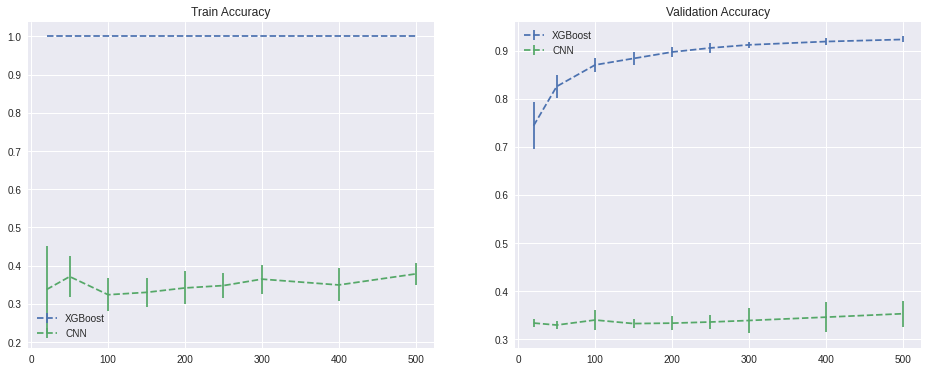

In [48]:
accuracies['xgb']['train'] # (9,16)
                            # np.mean(axis=1)

fig,axs = plt.subplots(1,2,figsize=[16,6])
# accuracy of train set
axs[0].set_title("Train Accuracy")
axs[0].errorbar(Ns_sub,np.mean(accuracies['xgb']['train'],axis=1),yerr=np.std(accuracies['xgb']['train'],axis=1),label='XGBoost',linestyle='--')
axs[0].errorbar(Ns_sub,np.mean(accuracies['cnn']['train'],axis=1),yerr=np.std(accuracies['cnn']['train'],axis=1),label='CNN',linestyle='--')
#accuracy of test set
axs[1].set_title("Validation Accuracy")
axs[1].errorbar(Ns_sub,np.mean(accuracies['xgb']['val'],axis=1),yerr=np.std(accuracies['xgb']['val'],axis=1),label='XGBoost',linestyle='--')
axs[1].errorbar(Ns_sub,np.mean(accuracies['cnn']['val'],axis=1),yerr=np.std(accuracies['cnn']['val'],axis=1),label='CNN',linestyle='--')

for ax in axs: ax.legend()
